In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. LOAD DATA
# For this example, you can download 'WA_Fn-UseC_-Telco-Customer-Churn.csv' from Kaggle
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# 2. BASIC CLEANING
# TotalCharges is often read as an object; convert to numeric and drop rows with nulls
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True) # ID is useless for prediction

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. IDENTIFY COLUMNS
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. CREATE PREPROCESSING PIPELINES
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. DEFINE THE FULL PIPELINE (Preprocessing + Model)
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# 6. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. HYPERPARAMETER TUNING (Grid Search)
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 8. EVALUATION
y_pred = grid_search.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))



Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
Accuracy: 0.7853589196872779
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



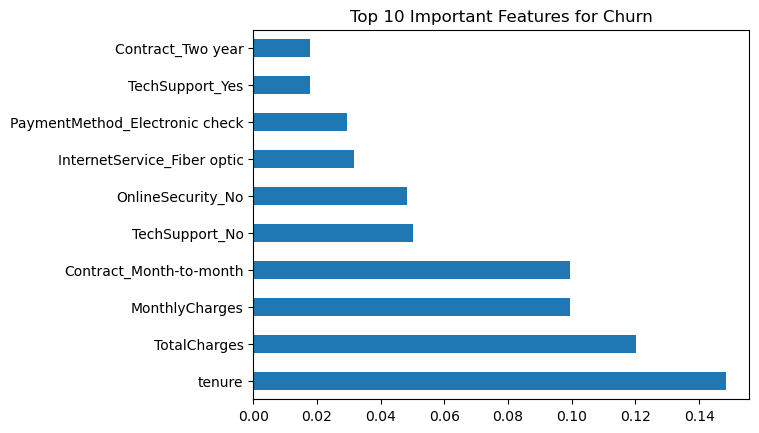

In [2]:
import matplotlib.pyplot as plt

# Get the model and feature names
best_model = grid_search.best_estimator_
feature_names = numeric_features.tolist() + \
                best_model.named_steps['preprocessor'].transformers_[1][1]\
                .named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

importances = best_model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 10
feat_imp.head(10).plot(kind='barh', title='Top 10 Important Features for Churn')
plt.show()

In [4]:
 #9. EXPORT THE PIPELINE
joblib.dump(grid_search.best_estimator_, 'churn_pipeline_model.joblib')
print("Model saved as churn_pipeline_model.joblib")

Model saved as churn_pipeline_model.joblib


In [5]:
import joblib
import pandas as pd

# 1. Load the "Saved Brain"
loaded_model = joblib.load('churn_pipeline_model.joblib')

# 2. Create a "Fake Customer" (Make sure column names match exactly)
# Let's create a customer who is likely to leave (Month-to-month contract, high charges)
fake_customer = pd.DataFrame([{
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 95.75,
    'TotalCharges': 95.75
}])

# 3. Use the model to predict
prediction = loaded_model.predict(fake_customer)
probability = loaded_model.predict_proba(fake_customer)

# 4. See the result
print(f"Prediction (1=Churn, 0=Stay): {prediction[0]}")
print(f"Confidence: {probability[0][prediction[0]]*100:.2f}%")

Prediction (1=Churn, 0=Stay): 1
Confidence: 76.94%
